In [22]:
%pip install mlforecast polars statsforecast

In [1]:
import mlforecast
import polars as pl
from datetime import datetime
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    AutoCES
)
from utilsforecast.losses import mse, rmse
from utilsforecast.evaluation import evaluate

In [2]:
pd_df = pd.read_csv('EURUSD_full_tickstory_data_hourly.csv')
pd_df.loc[:, 'EURUSD'] = 'EURUSD'
pd_df['Time'] = pd.to_datetime(pd_df['Time'])
pd_df = pd_df.rename(columns={
    'Close': 'y',
    'Time': 'ds',
    'EURUSD': 'unique_id'
})

,Time,Open,High,Low,Close,EURUSD
0,2016-08-01 03:00:00+00:00,1.11672,1.11767,1.11660,1.11750,EURUSD
1,2016-08-01 04:00:00+00:00,1.11750,1.11782,1.11683,1.11719,EURUSD
2,2016-08-01 05:00:00+00:00,1.11719,1.11753,1.11698,1.11709,EURUSD
3,2016-08-01 06:00:00+00:00,1.11710,1.11785,1.11662,1.11785,EURUSD
4,2016-08-01 07:00:00+00:00,1.11784,1.11814,1.11752,1.11794,EURUSD
...,...,...,...,...,...,...
50081,2024-08-09 19:00:00+00:00,1.09240,1.09245,1.09178,1.09186,EURUSD
50082,2024-08-09 20:00:00+00:00,1.09186,1.09234,1.09151,1.09206,EURUSD
50083,2024-08-09 21:00:00+00:00,1.09207,1.09217,1.09170,1.09195,EURUSD
50084,2024-08-09 22:00:00+00:00,1.09195,1.09211,1.09171,1.09187,EURUSD


In [40]:
df = (
    pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('ds').str.to_datetime(format='%Y-%m-%d %H:%M:%S+00:00'),
        # .dt.replace_time_zone('UTC'),
        pl.col('Close').alias('y').cast(pl.Float64)       
    ])
    .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y'))
    ).collect()
df

unique_id,ds,y
str,datetime[μs],f64
"""EURUSD""",2023-01-02 00:00:00,1.06929
"""EURUSD""",2023-01-02 01:00:00,1.07005
"""EURUSD""",2023-01-02 02:00:00,1.0704
"""EURUSD""",2023-01-02 03:00:00,1.06977
"""EURUSD""",2023-01-02 04:00:00,1.06904
…,…,…
"""EURUSD""",2024-08-09 19:00:00,1.09186
"""EURUSD""",2024-08-09 20:00:00,1.09206
"""EURUSD""",2024-08-09 21:00:00,1.09195


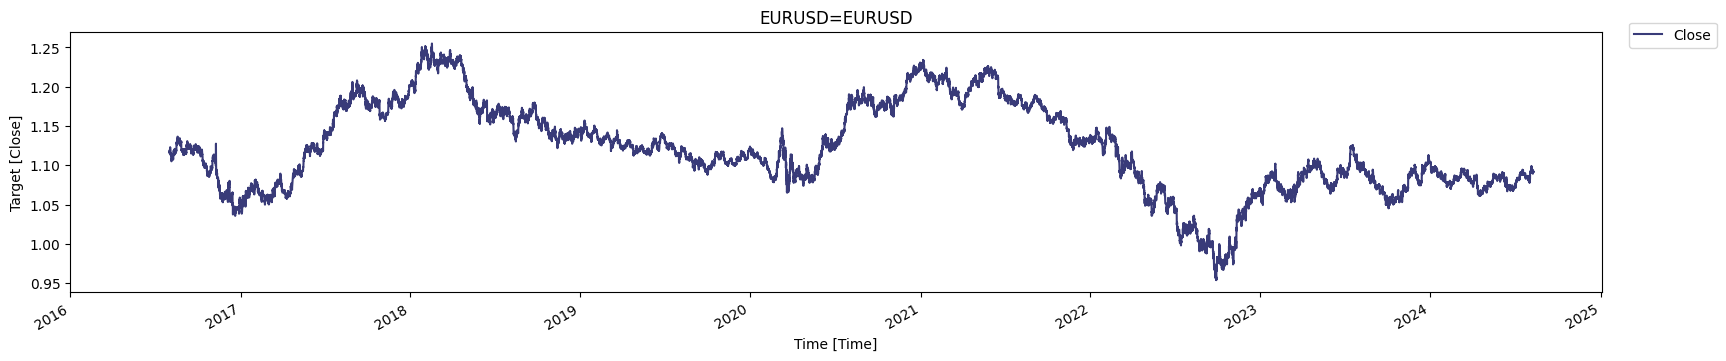

In [55]:
StatsForecast.plot(pd_df, id_col='EURUSD', time_col='Time', target_col='Close')

In [24]:
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(),
    HoltWinters(),
    SeasonalNaive(season_length=7),
    DOT(season_length=24),
    AutoCES(),
    AutoETS()
]
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='1h', 
    n_jobs=-1,
    fallback_model=SeasonalNaive(season_length=7),
    verbose=True
)


In [100]:
forecasts_df = sf.forecast(df=pd_df, h=48, level=[90])
forecasts_df.head()

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,
EURUSD,2024-08-10 00:00:00+00:00,1.09231,1.080352,1.104268,1.09231,1.080352,1.104268,1.09162,1.08006,1.10318,1.122011,1.02966,1.214363,1.091660,1.090087,1.093644
EURUSD,2024-08-10 01:00:00+00:00,1.09241,1.080452,1.104368,1.09241,1.080452,1.104368,1.09182,1.08026,1.10338,1.122011,1.02966,1.214363,1.091713,1.089335,1.094196
EURUSD,2024-08-10 02:00:00+00:00,1.09186,1.079902,1.103818,1.09186,1.079902,1.103818,1.09149,1.07993,1.10305,1.122011,1.02966,1.214363,1.091682,1.088235,1.094621
EURUSD,2024-08-10 03:00:00+00:00,1.09206,1.080102,1.104018,1.09206,1.080102,1.104018,1.09130,1.07974,1.10286,1.122011,1.02966,1.214363,1.091736,1.088248,1.094738
EURUSD,2024-08-10 04:00:00+00:00,1.09195,1.079992,1.103908,1.09195,1.079992,1.103908,1.09177,1.08021,1.10333,1.122011,1.02966,1.214363,1.091702,1.088113,1.095333


In [68]:
forecasts_df = sf.forecast(df=df, h=48, level=[90])
forecasts_df.head()


c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,EURUSD,2024-08-10 00:00:00+00:00,1.09231,1.080352,1.104268,1.09231,1.080352,1.104268,1.09162,1.08006,1.10318,1.122011,1.02966,1.214363,1.091660,1.090087,1.093644
1,EURUSD,2024-08-10 01:00:00+00:00,1.09241,1.080452,1.104368,1.09241,1.080452,1.104368,1.09182,1.08026,1.10338,1.122011,1.02966,1.214363,1.091713,1.089335,1.094196
2,EURUSD,2024-08-10 02:00:00+00:00,1.09186,1.079902,1.103818,1.09186,1.079902,1.103818,1.09149,1.07993,1.10305,1.122011,1.02966,1.214363,1.091682,1.088235,1.094621
3,EURUSD,2024-08-10 03:00:00+00:00,1.09206,1.080102,1.104018,1.09206,1.080102,1.104018,1.09130,1.07974,1.10286,1.122011,1.02966,1.214363,1.091736,1.088248,1.094738
4,EURUSD,2024-08-10 04:00:00+00:00,1.09195,1.079992,1.103908,1.09195,1.079992,1.103908,1.09177,1.08021,1.10333,1.122011,1.02966,1.214363,1.091702,1.088113,1.095333


In [97]:
# remove the 'HistoricAverage', 'HistoricAverage-lo-90', and 'HistoricAverage-hi-90'
rm_cols = ['HistoricAverage', 'HistoricAverage-lo-90', 'HistoricAverage-hi-90']
cols = [col for col in forecasts_df.columns if col not in rm_cols]
forecasts_df_sel = forecasts_df.loc[:, cols]

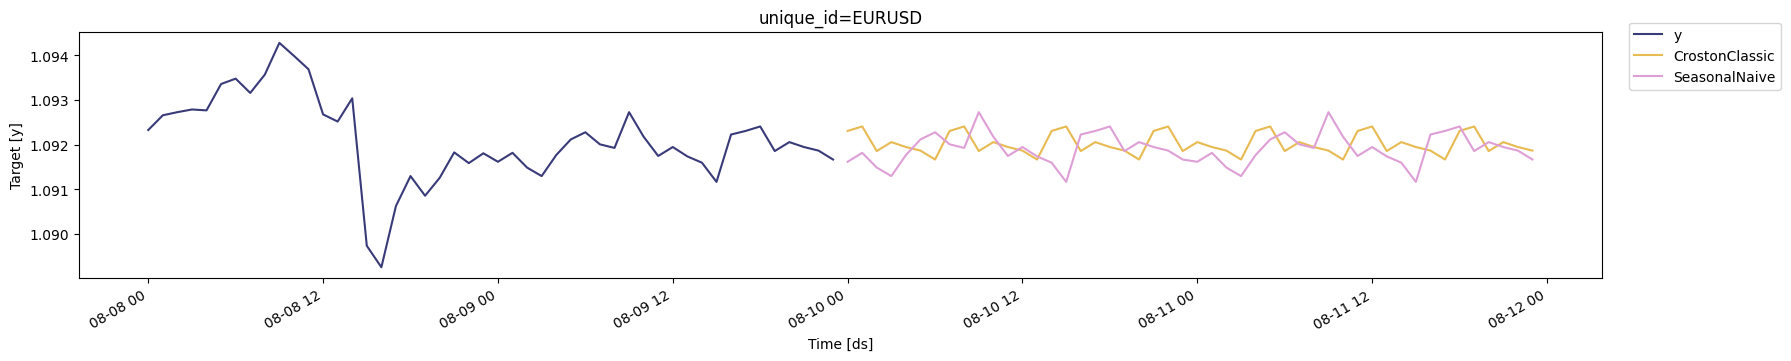

In [102]:
sf.plot(pd_df[(pd_df['ds'].dt.year >= 2024) & 
              (pd_df['ds'].dt.month >= 8) & 
              (pd_df['ds'].dt.day >= 8)], forecasts_df=forecasts_df_sel, models=['CrostonClassic', 'SeasonalNaive'], id_col='unique_id', time_col='ds', target_col='y')


In [104]:
len(pd_df[(pd_df['ds'].dt.year >= 2024) & 
              (pd_df['ds'].dt.month >= 1)])

3816

In [26]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=5,
    step_size=5,
    n_windows=3
)


Cross Validation Time Series 1:   0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
crossvaldation_df

unique_id,ds,cutoff,y,AutoARIMA,HoltWinters,SeasonalNaive,DynamicOptimizedTheta,CES,AutoETS
str,datetime[μs],datetime[μs],f32,f32,f32,f32,f32,f32,f32
"""EURUSD""",2024-08-09 09:00:00,2024-08-09 08:00:00,1.09273,1.091931,1.09149,1.09149,1.091963,1.091953,1.091931
"""EURUSD""",2024-08-09 10:00:00,2024-08-09 08:00:00,1.09218,1.091931,1.0913,1.0913,1.091951,1.091952,1.091931
"""EURUSD""",2024-08-09 11:00:00,2024-08-09 08:00:00,1.09175,1.091931,1.09177,1.09177,1.09195,1.091951,1.091931
"""EURUSD""",2024-08-09 12:00:00,2024-08-09 08:00:00,1.09195,1.091931,1.09212,1.09212,1.091975,1.091949,1.091931
"""EURUSD""",2024-08-09 13:00:00,2024-08-09 08:00:00,1.09174,1.091931,1.09228,1.09228,1.091956,1.091948,1.091931
…,…,…,…,…,…,…,…,…,…
"""EURUSD""",2024-08-09 19:00:00,2024-08-09 18:00:00,1.09186,1.092409,1.09195,1.09195,1.092428,1.092377,1.092409
"""EURUSD""",2024-08-09 20:00:00,2024-08-09 18:00:00,1.09206,1.092409,1.09174,1.09174,1.092467,1.092376,1.092409
"""EURUSD""",2024-08-09 21:00:00,2024-08-09 18:00:00,1.09195,1.092409,1.0916,1.0916,1.092473,1.092375,1.092409


In [18]:
# def evaluate_cross_validation(df, metric):
#     models = [c for c in df.columns if c not in ('unique_id', 'ds', 'cutoff', 'y')]

#     evals = []

#     # Calculate loss for every unique_id and cutoff.    
#     for cutoff in df['cutoff'].unique():
#         eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
#         evals.append(eval_)

#     evals = pd.concat(evals).drop('metric', axis=1)

#     # Calculate the mean of each 'unique_id' group
#     evals = evals.groupby('unique_id', as_index=False).mean()

#     # For each row in evals (excluding 'unique_id'), find the model with the lowest value
#     best_model = evals.drop('unique_id', axis=1).idxmin(axis=1)

#     # Add a 'best_model' column to evals dataframe with the best model for each 'unique_id'
#     evals['best_model'] = best_model

#     # Sort by 'unique_id'
#     evals = evals.sort_values('unique_id').reset_index(drop=True)

#     return evals
# evaluation_df = evaluate_cross_validation(crossvaldation_df, rmse)
# evaluation_df

AttributeError: 'DataFrame' object has no attribute 'reset_index'

In [29]:
def evaluate_cross_validation_polars(df, metric):
    models = [c for c in df.columns if c not in ('unique_id', 'ds', 'cutoff', 'y')]
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df.filter(pl.col('cutoff') == cutoff), metrics=[metric], models=models)
        evals.append(eval_)
    evals = pl.concat(evals).drop('metric')
    # Calculate the mean of each 'unique_id' group
    evals = evals.group_by(['unique_id'], maintain_order=True).mean() 

    # For each row in evals (excluding 'unique_id'), find the model with the lowest value
    best_model = [min(row, key=row.get) for row in evals.drop('unique_id').rows(named=True)]

    # Add a 'best_model' column to evals dataframe with the best model for each 'unique_id'
    evals = evals.with_columns(pl.Series(best_model).alias('best_model')).sort(by=['unique_id'])
    return evals
evaluation_df_polars = evaluate_cross_validation_polars(crossvaldation_df, rmse)
evaluation_df_polars

unique_id,AutoARIMA,HoltWinters,SeasonalNaive,DynamicOptimizedTheta,CES,AutoETS,best_model
str,f32,f32,f32,f32,f32,f32,str
"""EURUSD""",0.000485,0.000573,0.000573,0.000488,0.000468,0.000485,"""CES"""


# MLForecast

In [36]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)
# from numba import njit
# from window_ops.rolling import rolling_mean

fcst = MLForecast(
    models=[],
    freq='1h',    
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=3), RollingMean(window_size=6)],
    },
)
prep = fcst.preprocess(df)
prep

unique_id,ds,y,expanding_mean_lag1,rolling_mean_lag24_window_size3,rolling_mean_lag24_window_size6
str,"datetime[μs, UTC]",f64,f64,f64,f64
"""EURUSD""",2023-01-03 05:00:00 UTC,1.06722,1.067761,1.069267,1.06959
"""EURUSD""",2023-01-03 06:00:00 UTC,1.06672,1.067743,1.06932,1.069697
"""EURUSD""",2023-01-03 07:00:00 UTC,1.06634,1.06771,1.069433,1.069585
"""EURUSD""",2023-01-03 08:00:00 UTC,1.06521,1.067667,1.069417,1.069342
"""EURUSD""",2023-01-03 09:00:00 UTC,1.06236,1.067593,1.068727,1.069023
…,…,…,…,…,…
"""EURUSD""",2024-08-09 19:00:00 UTC,1.09186,1.081691,1.09093,1.090805
"""EURUSD""",2024-08-09 20:00:00 UTC,1.09206,1.081692,1.09114,1.090508
"""EURUSD""",2024-08-09 21:00:00 UTC,1.09195,1.081693,1.091317,1.090857


In [37]:
import lightgbm as lgb
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq='1h', 
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=3), RollingMean(window_size=6)],
    },
)
fcst.fit(df)


MLForecast(models=[avg, q75, q25], freq=1h, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size3', 'rolling_mean_lag24_window_size6'], date_features=[], num_threads=1)

In [41]:
preds = fcst.predict(10)
preds


unique_id,ds,avg,q75,q25
str,datetime[μs],f64,f64,f64
"""EURUSD""",2024-08-10 00:00:00,1.091564,1.091725,1.091414
"""EURUSD""",2024-08-10 01:00:00,1.091735,1.091633,1.091288
"""EURUSD""",2024-08-10 02:00:00,1.091549,1.091717,1.091113
"""EURUSD""",2024-08-10 03:00:00,1.091825,1.091689,1.09092
"""EURUSD""",2024-08-10 04:00:00,1.091806,1.091783,1.090988
"""EURUSD""",2024-08-10 05:00:00,1.091597,1.091826,1.090907
"""EURUSD""",2024-08-10 06:00:00,1.091594,1.091948,1.090793
"""EURUSD""",2024-08-10 07:00:00,1.091591,1.091921,1.090751
"""EURUSD""",2024-08-10 08:00:00,1.091473,1.091931,1.090707


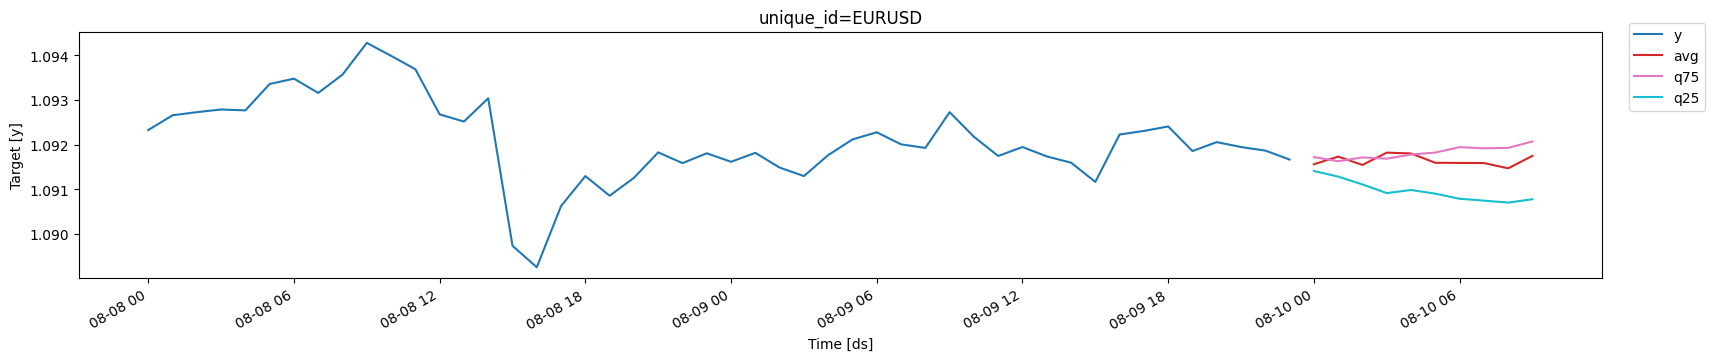

In [44]:
from utilsforecast.plotting import plot_series

fig = plot_series(df, preds, max_insample_length=48)
fig